In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [259]:
from numpy.linalg import norm
from numpy import dot

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [154]:
from keras.layers import Dense, Input, Embedding, Flatten, Dropout, Dot, Reshape
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.utils import shuffle

### Ratings data prep

In [9]:
ratings = pd.read_csv('goodbooks-10k-master/ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [25]:
ratings['scaled_rating'] = (ratings['rating'] - 1) / 4
ratings.groupby('scaled_rating')['rating'].count()

scaled_rating
0.00     124195
0.25     359257
0.50    1370916
0.75    2139018
1.00    1983093
Name: rating, dtype: int64

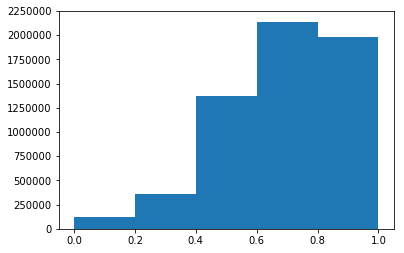

In [23]:
plt.hist(ratings['scaled_rating'],5)
plt.show()

In [227]:
train,test = train_test_split(ratings,test_size=0.6)
train.shape

(2390591, 4)

In [228]:
train_books = np.array(train['book_id'])
train_users = np.array(train['user_id'])
train_ratings = np.array(train['scaled_rating'])

In [229]:
train_books,train_users,train_ratings = shuffle([train_books,train_users,train_ratings])

### Define explicit Matrix Factorization model with Keras

In [182]:
nr_books = max(ratings['book_id'])
nr_books

10000

In [183]:
nr_users = max(ratings['user_id'])
nr_users

53424

In [230]:
EMBEDDING_DIM = 8

In [231]:
user_input = Input(shape=(1,),dtype='int32', name="UserInput")

In [232]:
user_embedding = Embedding(input_dim=nr_users+1,
                               output_dim=EMBEDDING_DIM,
                               input_length=1,
                               trainable=True,
#                               embeddings_regularizer=regularizers.l2(0.0001),
                               name="UserEmbedding")(user_input)

In [233]:
user_embedding = Reshape(target_shape=(EMBEDDING_DIM,))(user_embedding)
user_embedding.shape

TensorShape([Dimension(None), Dimension(8)])

In [234]:
book_input = Input(shape=(1,),dtype='int32', name="BookInput")

In [235]:
book_embedding = Embedding(input_dim=nr_books+1,
                               output_dim=EMBEDDING_DIM,
                               input_length=1,
                               trainable=True,
#                               embeddings_regularizer=regularizers.l2(0.0001), 
                               name="BookEmbedding")(book_input)

In [236]:
book_embedding = Reshape(target_shape=(EMBEDDING_DIM,))(book_embedding)
book_embedding.shape

TensorShape([Dimension(None), Dimension(8)])

In [237]:
dot_prod = Dot(axes=1)([book_embedding,user_embedding])
dot_prod.shape

TensorShape([Dimension(None), Dimension(1)])

In [238]:
linear_out = Dense(activation='sigmoid',units=1
                  # ,kernel_regularizer=regularizers.l2(0.0001)
                  )(dot_prod)
linear_out.shape

TensorShape([Dimension(None), Dimension(1)])

In [245]:
embedding_model0 = Model(inputs=[book_input,user_input], outputs=[linear_out])

In [249]:
embedding_model0.compile(loss='mean_absolute_error'
                         , optimizer='adam'
                         ,metrics=['mean_squared_error','mean_absolute_error'])

In [250]:
embedding_model0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
BookInput (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
UserInput (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
BookEmbedding (Embedding)        (None, 1, 8)          80008       BookInput[0][0]                  
____________________________________________________________________________________________________
UserEmbedding (Embedding)        (None, 1, 8)          427400      UserInput[0][0]                  
___________________________________________________________________________________________

### Train model

In [251]:
model0_hist = embedding_model0.fit([train['book_id'],train['user_id']], train['scaled_rating'],
    epochs=1, 
    batch_size=64,
    validation_data=([test['book_id'],test['user_id']], test['scaled_rating'])
)

Train on 2390591 samples, validate on 3585888 samples
Epoch 1/1
2390591/2390591 [==============================] - 360s - loss: 0.1860 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1860 - val_loss: 0.1859 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1859


In [ ]:
# Train on 597647 samples, validate on 5378832 samples
# Epoch 1/1
# 597647/597647 [==============================] - 245s - loss: 0.6358 - mean_squared_error: 0.5943 - val_loss: 0.6350 - val_mean_squared_error: 0.5942

In [205]:
embedding_model0.save('models/explicit_mf_keras')

### Check model predictions

In [252]:
test_predict = embedding_model0.predict([test['book_id'],test['user_id']])
#embedding_model0.predict([test['book_id'][110:120],test['user_id'][110:120]])

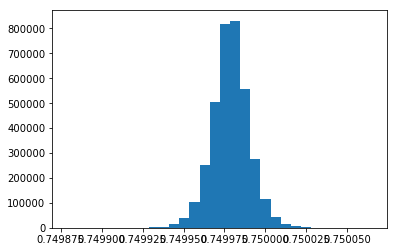

In [253]:
plt.hist(test_predict,30)
plt.show()

### Examine book embeddings

In [254]:
book_vectors = embedding_model0.layers[2].get_weights()[0]

In [263]:
def cosine_sim(a,b):
    return dot(a,b) / (norm(a)*norm(b))

In [257]:
books = pd.read_csv('goodbooks-10k-master/books.csv')
books.head(30)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,2001311,2078754,25112,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,2035490,2191465,49152,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...


In [269]:
book_vectors[1]

array([ 0.11988614,  0.14553565,  0.07982843,  0.09319461,  0.15478563,
        0.25471434,  0.06450768, -0.05145309], dtype=float32)

In [273]:
# Hunger Games vs. Catching Fire
cosine_sim(book_vectors[1],book_vectors[17])

-0.48487556

In [268]:
# Harry potter #2 vs. Harry potter #3
cosine_sim(book_vectors[22],book_vectors[17])

0.08413236

Well things don't look too good based on these...